## Строим инструмент для иллюстрации новостей в Yandex DataSphere

Задача: создать инструмент для генерации иллюстраций к новостям на китайском языке. Будем использовать:
* Yandex Translate для перевода
* YandexGPT для генерации промпта
* YandexART для рисования

Основная идея - использовать большую языковую модель для суммаризации и генерации промпта для генеративной модели, работающей с изображениями.

Для примера возьмём новость с сайта популярной китайской газеты [Гуанмин Жибао](http://gmw.cn/)

In [1]:
text = """
　作者：浙江大学长三角一体化发展研究中心课题组

　　长三角地区包括上海、江苏、浙江、安徽三省一市，以不足4%的国土面积，集聚了全国约17%的人口，创造出全国近四分之一的经济总量，在全国经济板块中具有举足轻重的地位。2018年11月，习近平总书记在上海宣布，支持长江三角洲区域一体化发展并上升为国家战略。2019年5月，习近平总书记主持召开中共中央政治局会议，审议通过《长江三角洲区域一体化发展规划纲要》，为长三角一体化发展举旗定向、擘画蓝图。长三角一体化发展的第一个五年间，三省一市紧扣一体化和高质量两个关键词，不断推动“蓝图规划”变为“现实画卷”，长三角成为我国经济最活跃、开放程度最高、创新能力最强的区域之一。

今年4月30日，中共中央政治局召开会议，审议《关于持续深入推进长三角一体化高质量发展若干政策措施的意见》，提出要加快突破关键核心技术，统筹推进传统产业升级、新兴产业壮大、未来产业培育，在更大范围内联动构建创新链、产业链、供应链。当前，新一轮科技革命和产业变革与我国加快培育发展新质生产力形成了历史性交汇，长三角一体化发展已迈入“第二个五年”，如何在高质量发展基础上向“新”提质、积“势”成力，成为我国培育、发展和释放新质生产力的高地和窗口，是长三角三省一市必须回答的新课题。
"""

Первым делом нам нужно перевести эту новость на русский язык, поскольку YandexGPT использует русский язык как базовый. Для этого нам нужно научиться вызывать Yandex Translate API.

Все API вызываются похожим образом: для авторизации необходимо передать либо IAM-токен (с коротким сроком жизни), либо ключ API Key.

Для создания ключа API Key нам необходимо:
* Создать в облаке сервисный аккаунт, имеющий нужные права
* Сгенерировать для этого аккаунта ключ API Key
* Разместить ключ в виде секрета Datasphere

In [3]:
import requests
import os

def call_api(url, data):
    headers = { "Authorization" : f"Api-Key {os.environ['api_key']}" }
    return requests.post(url, json=data, headers=headers).json()
    
call_api("https://translate.api.cloud.yandex.net/translate/v2/translate",
{
  "targetLanguageCode" : "ru",
  "texts" : [text]
})
    

{'translations': [{'text': '\n\u3000Автор: Исследовательская группа, Исследовательский центр интеграции и развития дельты реки Янцзы, Чжэцзянский университет\n\n\u3000\u3000Регион дельты реки Янцзы включает в себя три провинции и один город - Шанхай, Цзянсу, Чжэцзян и Аньхой. На его территории, занимающей менее 4% территории страны, проживает около 17% населения и создается почти четверть всей экономики страны. Он занимает важное положение в народнохозяйственном секторе.В ноябре 2018 года Генеральный секретарь Си Цзиньпин объявил в Шанхае, что он поддерживает развитие региональной интеграции в дельте реки Янцзы и продвигает ее в качестве национальной стратегии.В мае 2019 года Генеральный секретарь Си Цзиньпин председательствовал на заседании Политбюро Центрального комитета Коммунистической партии Китая, на котором был рассмотрен и принят "План регионального интеграционного развития дельты реки Янцзы", чтобы поднять флаг и составить план комплексного развития дельты реки Янцзы.В течение

Оформим фукцию перевода в виде отдельной функции:

In [4]:
def translate(text, target_language="ru"):
    res = call_api("https://translate.api.cloud.yandex.net/translate/v2/translate",
    {
      "targetLanguageCode" : target_language,
      "texts" : [text]})
    return res['translations'][0]['text']
    
text_ru = translate(text)
text_ru

'\n\u3000Автор: Исследовательская группа, Исследовательский центр интеграции и развития дельты реки Янцзы, Чжэцзянский университет\n\n\u3000\u3000Регион дельты реки Янцзы включает в себя три провинции и один город - Шанхай, Цзянсу, Чжэцзян и Аньхой. На его территории, занимающей менее 4% территории страны, проживает около 17% населения и создается почти четверть всей экономики страны. Он занимает важное положение в народнохозяйственном секторе.В ноябре 2018 года Генеральный секретарь Си Цзиньпин объявил в Шанхае, что он поддерживает развитие региональной интеграции в дельте реки Янцзы и продвигает ее в качестве национальной стратегии.В мае 2019 года Генеральный секретарь Си Цзиньпин председательствовал на заседании Политбюро Центрального комитета Коммунистической партии Китая, на котором был рассмотрен и принят "План регионального интеграционного развития дельты реки Янцзы", чтобы поднять флаг и составить план комплексного развития дельты реки Янцзы.В течение первых пяти лет комплексно

Далее нам нужно использовать YandexGPT для суммаризации статьи. Этот вызов также можно сделать через API, но для простоты мы будем использовать готовую библиотеку [yandex_chain](http://github.com/yandex-datasphere/yandex-chain], которая предоставляет интерфейс работы с YandexGPT в рамах популярного фреймворка LangChain.

In [4]:
%pip install yandex_chain 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


Для суммаризации будем использовать модель YandexGPT Pro. Нам нужно будет разработать такой промпт, который будет приводить к хорошим результатам, т.е. к не слишком длинному ответу, чтобы при этом промпт содержал нужные визуальные образы. Такой промпт придётся подобрать!

In [9]:
from yandex_chain import YandexLLM, YandexGPTModel

folder_id = os.environ['folder_id']

gpt = YandexLLM(folder_id=folder_id, api_key=os.environ['api_key'], model=YandexGPTModel.Pro)
gpt.instruction_text="""
Ты - профессиональный редактор новостей. Твоя задача - понять, какая картинка подойдёт
к конкретной новости, и написать её краткой описание в виде промпта для генеративной нейросети YandexART.
Прочитай текст новости ниже и напиши промпт с описанием релевантной картинки. В промпте должны быть
чёткие описание конкретных объектов, которые необходимо нарисовать. В качестве ответа выведи только
текст промпта для Yandex ART, не пиши никакого дополнительного текста. Промпт должен быть короткий, не более
5 строчек текста.
"""
res = gpt.invoke(text)
res

'**Изображение:** карта с выделенными провинциями Чжэцзян, Цзянсу и Аньхой, а также Шанхаем, с условными обозначениями, показывающими ключевые направления развития в рамках плана по интеграции региона «Чан Сань Чжоу».\n\n**Текст:** Создайте карту региона Чан Сань Чжоу, расположенного на территории Китая, включающего провинции Чжэцзян, Цзянсу, Аньхой и город Шанхай. На карте должны быть отображены основные направления интеграции и развития, которые определены в плане по интеграции этого региона.'

Далее нужно вызвать YandexART для генерации изображения. YandexART работает в асинхронном режиме: мы сначала ставим запрос в очередь генерации, и потом проверяем готовность по выданному нам ID.

Опишем функцию для подачи изображения на генерацию:

In [10]:
def submit_art(prompt):
    res = call_api("https://llm.api.cloud.yandex.net/foundationModels/v1/imageGenerationAsync",
    {
        "modelUri": f"art://{folder_id}/yandex-art/latest",
        "messages": [
          {
            "weight": 1,
            "text": prompt
          }
        ]
    })
    if 'error' in res:
        print(res)
        return None
    return res['id']

id = submit_art(res)
id

'fbvctpq37b1pcpe565hn'

Для проверки готовности изображения и получения результатов необходимо использовать GET-запрос, поэтому создаём ещё одну функцию `call_api_get`. Изображение возвращается в виде Base-64 Encoding, поэтому мы определяем функцию для декодирования изображения.

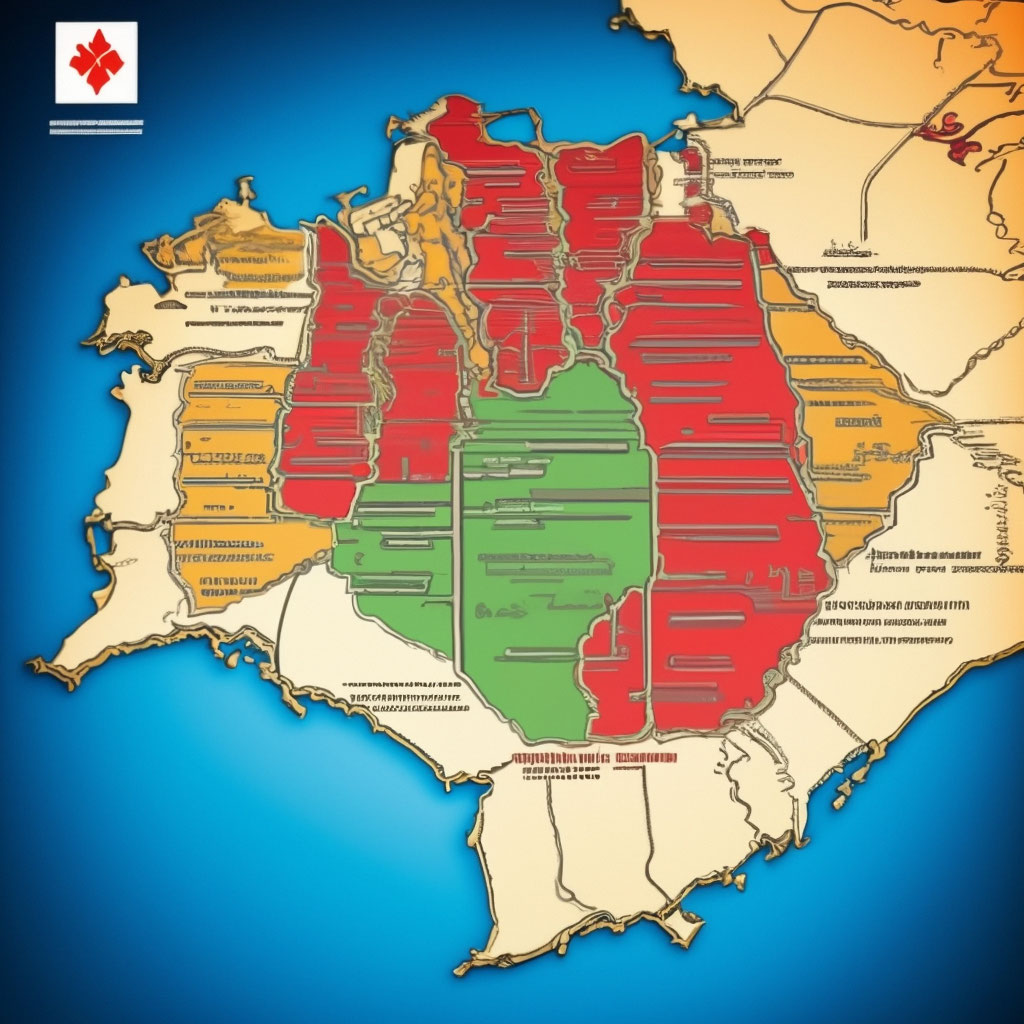

In [11]:
import io
from PIL import Image
import base64

def call_api_get(url, data):
    headers = { "Authorization" : f"Api-Key {os.environ['api_key']}" }
    return requests.get(url, headers=headers).json()

def decode_image(base64_str):
    return Image.open(io.BytesIO(base64.decodebytes(bytes(base64_str, "utf-8"))))

def check(id):
    res = call_api_get(f"https://llm.api.cloud.yandex.net:443/operations/{id}",{})
    if 'done' in res and res['done']:
        return decode_image(res['response']['image'])
    else:
        return None
    
res = check(id)
res

## Реализация интерфейса

Для создания пользовательского интерфейса придумываем самый простой подход, который позволяет дать проект потестировать жюри. Например, можно раализовать интерфейс в виде телеграм-бота прямо в Yandex Datasphere. Будем использовать режим polling, и библиотеку `telebot`:

In [23]:
%pip install telebot

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 555.0 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.9/242.9 kB 1.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


Для простоты будем считать, что любое сообщение боту (кроме '/start') представляет собой текст статьи. Также для простоты релизуем подход, при котором во всё время генерации изображения бот не обрабатывает сообщения от других пользователей.

In [12]:
import telebot, time
from io import BytesIO

bot = telebot.TeleBot(os.environ['tg_token'])

@bot.message_handler(content_types=['text'])
def get_text_messages(message):
    if message=='/start':
        bot.send_message(message.from_user.id, f"Yo!")
        return
    print('Translating')
    text_ru = translate(message.text)
    print('Extracting prompt')
    res = gpt.invoke(text_ru)
    bot.send_message(message.from_user.id, f"Я побежал рисовать по запросу {res}")
    print('Sumbitting to ART')
    id = submit_art(res)
    if not id:
        bot.send_message(message.from_user.id, f"Что-то пошло не так")
        return
    while True:
        time.sleep(5)
        print('Checking')
        res = check(id)
        if res:
            break
    bio = BytesIO()
    bio.name = 'image.jpeg'
    res.save(bio, 'JPEG')
    bio.seek(0)
    bot.send_photo(message.from_user.id, photo=bio)
    
bot.polling(non_stop=True, interval=2)
        

Translating
Extracting prompt
Sumbitting to ART
{'error': 'it is not possible to generate an image from this request because it may violate the terms of use', 'code': 3, 'message': 'it is not possible to generate an image from this request because it may violate the terms of use', 'details': []}
Translating
Extracting prompt
Sumbitting to ART
{'error': 'it is not possible to generate an image from this request because it may violate the terms of use', 'code': 3, 'message': 'it is not possible to generate an image from this request because it may violate the terms of use', 'details': []}
Translating
Extracting prompt
Sumbitting to ART
Checking
Checking
Checking
Checking


 Тот факт, что бот не обрабатывает запросы во время генерации изображения сильно снижает его практическую применимость. Стоит подумать над архитектурой, когда запросы после отправки на генерацию откладываются в очередь, и потом проверяются на готовность.
 
Другой возможный подход к построению интерфейсов - простые Python-библиотеки для прототипирования интерфейсов, напобие [gradio](https://www.gradio.app/) или [StreamLit](https://streamlit.io/). 

In [34]:
%pip install gradio

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 1.3 MB/s eta 0:00:00a 0:00:01
INFO: pip is looking at multiple versions of requests to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 54.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 58.0 MB/s eta 0:00:

Простейшее приложение Gradio - это по сути Python-функция, которая перерабатывает вход в выход. На входе в нашем случае текст статьи, на выходе - картинка. 

Использование параметра `share=True` в фунции `launch` позволяет получить "внешнюю" ссылку на приложение, которая будет доступна отовсюду из интернета.

In [13]:
import gradio as gr
import time

def greet(text):
    print('Translating')
    text_ru = translate(text)
    print('Extracting prompt')
    res = gpt.invoke(text_ru)
    print('Sumbitting to ART')
    id = submit_art(res)
    if not id:
        print("Error")
        return None
    while True:
        time.sleep(5)
        print('Checking')
        res = check(id)
        if res:
            break
    return res

demo = gr.Interface(
    fn=greet,
    inputs=["text"],
    outputs=["image"],
)

print("Launching...")
demo.launch(share=True)
print("Done")

Launching...
Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://a83a16798fff15d136.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Done
Translating
Extracting prompt
Sumbitting to ART
Checking
Checking
Checking
Checking


## Выводы

1. Многие сложные задачи, для решения которых раньше нужно было обучать свои модели, сейчас могут решаться с помощью больших языковых моделей. По крайней мере на хакатоне.
1. По максимуму можно использовать готовые сервисы облака: OCR, SpeechKit, Translate
1. Использование адекватных задаче технологий для построения пользовательских интерфейсов (Telegram Bot, Gradio) позволяет предоставить жюри доступ к вашему решению с минимальными затратами времени.